### 과제 2: 배송 성과 분석
**과제 2: 배송 성과 분석 및 지역별 물류 최적화 방안**
주문부터 배송 완료까지의 시간을 분석하고, 지역별 배송 성과 차이를 파악하여 물류 최적화 방안을 도출하세요. 배송 지연이 고객 만족도(리뷰 점수)에 미치는 영향도 함께 분석하세요



## EDA 진행 
**목표:** 지역별 배송 시간의 평균과 분포를 확인하고, 배송 시간과 고객 리뷰 점수 간의 관계를 파악합니다.

### **분석 로직:**

1. **날짜/시간 변환**: `orders` 데이터셋의 `order_purchase_timestamp`와 `order_delivered_customer_date`를 `datetime` 타입으로 변환합니다.
2. **배송 시간 계산**: `order_delivered_customer_date`에서 `order_purchase_timestamp`를 빼서 배송 소요 시간을 계산합니다.
3. **데이터 병합**: `orders`와 `geolocation` 데이터셋을 병합하여 주문별 지역 정보를 추가합니다. 또한, `orders`와 `reviews` 데이터셋을 병합하여 주문별 리뷰 점수를 연결합니다.
4. **지역별 분석**: `customer_state`를 기준으로 그룹화하여 지역별 평균 배송 시간을 계산합니다.
5. **상관관계 분석**: 배송 소요 시간과 `review_score` 간의 상관계수를 계산합니다.

### **시각화 계획:**

- **박스플롯**: 지역별(주/도시) 배송 시간의 분포를 한눈에 비교하기 위해 박스플롯을 그립니다.
- **산점도**: 배송 소요 시간과 리뷰 점수 간의 관계를 시각적으로 확인하기 위해 산점도를 그립니다.
- **히스토그램**: 리뷰 점수별(1~5점) 배송 소요 시간의 분포를 비교하는 히스토그램을 그립니다.


오늘 진행할 내용은  
**과제 2: 배송 성과 분석 및 지역별 물류 최적화 방안**
주문부터 배송 완료까지의 시간을 분석하고, 지역별 배송 성과 차이를 파악하여 물류 최적화 방안을 도출하세요. 배송 지연이 고객 만족도(리뷰 점수)에 미치는 영향도 함께 분석 




# 데이터 전처리 코드 

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
# 폰트 깨짐 방지: Matplotlib에 한글 폰트 설정
plt.rc('font', family='AppleGothic')
# 마이너스 기호 깨짐 방지
plt.rc('axes', unicode_minus=False)
# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 주요 테이블 로딩

customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
category_name = pd.read_csv("product_category_name_translation.csv")
geolocation= pd.read_csv("olist_geolocation_dataset.csv")


### 데이터 형 변환 (포르투갈어-> 영어, date_time 형식으로 변환)

In [2]:
# 각 데이터셋 크기 확인
datasets = {
    "customers": customers,
    "orders": orders,
    "order_items": order_items,
    "products": products,
    "sellers": sellers,
    "payments": payments,
    "reviews": reviews,
    "category_name": category_name,
    "geolocation": geolocation
}

for name, df in datasets.items():
    print(f"{name}: {df.shape}")
    display(df.head(2))  # 앞부분 2행만 미리보기


# ======================
# [1] Products 카테고리명 번역 (포르투갈어 → 영어)
# ======================
products = pd.read_csv("olist_products_dataset.csv")
category_translation = pd.read_csv("product_category_name_translation.csv")

# 병합 후 컬럼 정리
products = (
    products.merge(category_translation, on="product_category_name", how="left")
            .drop("product_category_name", axis=1)
            .rename(columns={"product_category_name_english": "product_category_name"})
)

print("\n=== 변환 후 'products' 카테고리 예시 ===")
print(products["product_category_name"].head())


# ======================
# [2] Orders 날짜 컬럼 변환
# ======================
datetime_cols = [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]
# orders 데이터셋의 모든 날짜/시간 관련 컬럼을 datetime 타입으로 변환
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])



# ======================
# [3] Reviews 날짜 컬럼 변환
# ======================
reviews[["review_creation_date", "review_answer_timestamp"]] = reviews[
    ["review_creation_date", "review_answer_timestamp"]
].apply(pd.to_datetime, errors="coerce")

print("\n=== Reviews 날짜 컬럼 dtype 확인 ===")
print(reviews[["review_creation_date", "review_answer_timestamp"]].dtypes)




customers: (99441, 5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


orders: (99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


order_items: (112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


products: (32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


sellers: (3095, 4)


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


payments: (103886, 5)


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


reviews: (99224, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


category_name: (71, 2)


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


geolocation: (1000163, 5)


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP



=== 변환 후 'products' 카테고리 예시 ===
0         perfumery
1               art
2    sports_leisure
3              baby
4        housewares
Name: product_category_name, dtype: object

=== Reviews 날짜 컬럼 dtype 확인 ===
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object


### 결측치 처리

- orders: 배송 완료일(order_delivered_customer_date) 없는 주문 제거 ✅
- orders: 결제 승인일(order_approved_at) 없는 주문 제거 ✅
- reviews: 코멘트 결측치 → "no comment" 대체 ✅

In [3]:
# orders 데이터셋을 불러옵니다.
# 사용자 정의 변수명을 참조하여 코드를 작성합니다.
print("=== 'orders' 데이터셋 결측치 현황 ===")
print(orders.isnull().sum())

# 배송 완료일(`order_delivered_customer_date`)이 없는 주문은 배송이 완료되지 않은 상태입니다.
# 배송 성과 분석을 위해 이 행들을 제거합니다.
orders.dropna(subset=['order_delivered_customer_date'], inplace=True)
print("\n배송 미완료 주문 제거 후 데이터 크기:", orders.shape)

# 추가적으로, 결제 승인일(`order_approved_at`)이 없는 주문도 분석에서 제외할 수 있습니다.
# 이는 유효하지 않은 주문으로 간주될 수 있기 때문입니다.
orders.dropna(subset=['order_approved_at'], inplace=True)
print("\n결제 미승인 주문 제거 후 최종 데이터 크기:", orders.shape)
print("\n결제 미승인 주문 제거 후 최종 데이터 크기:", orders .shape)


# 결측치가 제거된 최종 데이터셋의 결측치 현황을 다시 확인합니다.
print("\n=== 최종 데이터셋 결측치 재확인 ===")
print(orders.isnull().sum())

# 결측치가 제거된 데이터셋의 상위 5개 행을 확인합니다.
print("\n=== 최종 데이터셋 미리보기 ===")
print(orders.head())

# reviews 데이터셋을 불러옵니다.
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

print("=== 'olist_order_reviews_dataset.csv' 결측치 현황 ===")
print(reviews.isnull().sum())

# 코멘트 관련 컬럼(`review_comment_title`, `review_comment_message`)의 결측치는
# 고객이 코멘트를 남기지 않았음을 의미하므로, 'no comment'로 채울 수 있습니다.
reviews['review_comment_title'].fillna('no comment', inplace=True)
reviews['review_comment_message'].fillna('no comment', inplace=True)

print("\n결측치 처리 후 현황:")
print(reviews.isnull().sum())

=== 'orders' 데이터셋 결측치 현황 ===
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

배송 미완료 주문 제거 후 데이터 크기: (96476, 8)

결제 미승인 주문 제거 후 최종 데이터 크기: (96462, 8)

결제 미승인 주문 제거 후 최종 데이터 크기: (96462, 8)

=== 최종 데이터셋 결측치 재확인 ===
order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     1
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

=== 최종 데이터셋 미리보기 ===
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20de

## 이상값 처리

- 이상치 처리
    - orders: 배송 소요일(delivery_time_days) IQR 기반 제거 ✅
    - order_items: 가격(price) IQR 기반 제거 ✅
    - products: 무게(product_weight_g) IQR 기반 제거 ✅
    - payments: 결제 금액(payment_value) IQR 기반 제거 ✅

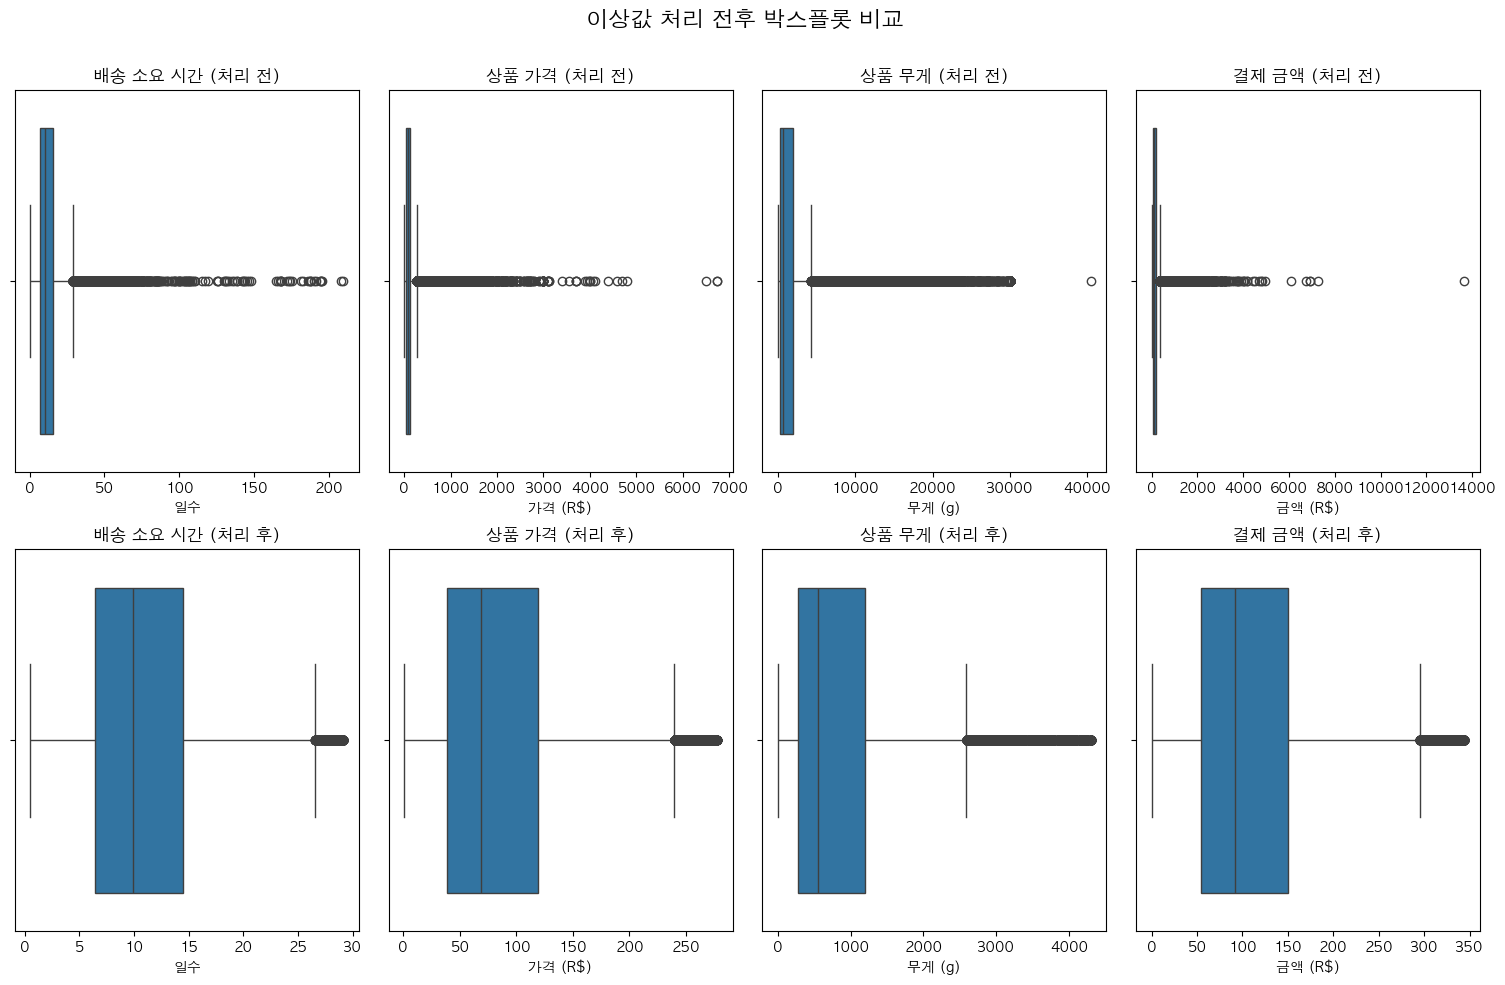

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터셋 불러오기
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")

# 폰트 깨짐 방지: Matplotlib에 한글 폰트 설정
plt.rc('font', family='AppleGothic')
# 마이너스 기호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# orders 데이터 날짜 변환 및 배송 소요 시간 계산
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders.dropna(subset=['order_delivered_customer_date'], inplace=True)
orders['delivery_time_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# 시각화를 위한 원본 데이터 복사
orders_original = orders.copy()
order_items_original = order_items.copy()
products_original = products.copy()
payments_original = payments.copy()

# =================================================================
# 이상값 처리 및 시각화
# =================================================================

fig, axes = plt.subplots(2, 4, figsize=(15, 10))
fig.suptitle('이상값 처리 전후 박스플롯 비교', fontsize=16)

# ----------------- 배송 소요 시간 (orders) -----------------
# 처리 전
sns.boxplot(x=orders_original['delivery_time_days'], ax=axes[0, 0])
axes[0, 0].set_title('배송 소요 시간 (처리 전)')
axes[0, 0].set_xlabel('일수')

# 이상값 처리
Q1 = orders['delivery_time_days'].quantile(0.25)
Q3 = orders['delivery_time_days'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
orders_cleaned = orders[(orders['delivery_time_days'] >= lower_bound) & (orders['delivery_time_days'] <= upper_bound)]

# 처리 후
sns.boxplot(x=orders_cleaned['delivery_time_days'], ax=axes[1, 0])
axes[1, 0].set_title('배송 소요 시간 (처리 후)')
axes[1, 0].set_xlabel('일수')

# ----------------- 상품 가격 (order_items) -----------------
# 처리 전
sns.boxplot(x=order_items_original['price'], ax=axes[0, 1])
axes[0, 1].set_title('상품 가격 (처리 전)')
axes[0, 1].set_xlabel('가격 (R$)')

# 이상값 처리
Q1 = order_items['price'].quantile(0.25)
Q3 = order_items['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
order_items_cleaned = order_items[(order_items['price'] >= lower_bound) & (order_items['price'] <= upper_bound)]

# 처리 후
sns.boxplot(x=order_items_cleaned['price'], ax=axes[1, 1])
axes[1, 1].set_title('상품 가격 (처리 후)')
axes[1, 1].set_xlabel('가격 (R$)')

# ----------------- 상품 무게 (products) -----------------
# 처리 전
sns.boxplot(x=products_original['product_weight_g'], ax=axes[0, 2])
axes[0, 2].set_title('상품 무게 (처리 전)')
axes[0, 2].set_xlabel('무게 (g)')

# 이상값 처리
Q1 = products['product_weight_g'].quantile(0.25)
Q3 = products['product_weight_g'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
products_cleaned = products[(products['product_weight_g'] >= lower_bound) & (products['product_weight_g'] <= upper_bound)]

# 처리 후
sns.boxplot(x=products_cleaned['product_weight_g'], ax=axes[1, 2])
axes[1, 2].set_title('상품 무게 (처리 후)')
axes[1, 2].set_xlabel('무게 (g)')

# ----------------- 결제 금액 (payments) -----------------
# 처리 전
sns.boxplot(x=payments_original['payment_value'], ax=axes[0, 3])
axes[0, 3].set_title('결제 금액 (처리 전)')
axes[0, 3].set_xlabel('금액 (R$)')

# 이상값 처리
Q1 = payments['payment_value'].quantile(0.25)
Q3 = payments['payment_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
payments_cleaned = payments[(payments['payment_value'] >= lower_bound) & (payments['payment_value'] <= upper_bound)]

# 처리 후
sns.boxplot(x=payments_cleaned['payment_value'], ax=axes[1, 3])
axes[1, 3].set_title('결제 금액 (처리 후)')
axes[1, 3].set_xlabel('금액 (R$)')

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()



### 데이터 병합 merge 및 중복값 제거 

In [5]:

# orders와 customers 병합 (customer_id 기준)
df_merged = pd.merge(orders, customers, on='customer_id', how='left')

# df_merged와 order_items 병합 (order_id 기준)
df_merged = pd.merge(df_merged, order_items, on='order_id', how='left')

# df_merged와 payments 병합 (order_id 기준)
df_merged = pd.merge(df_merged, payments, on='order_id', how='left')

# df_merged와 reviews 병합 (order_id 기준)
df_merged = pd.merge(df_merged, reviews, on='order_id', how='left')

# df_merged와 products 병합 (product_id 기준)
df_merged = pd.merge(df_merged, products, on='product_id', how='left')

# df_merged와 sellers 병합 (seller_id 기준)
df_merged = pd.merge(df_merged, sellers, on='seller_id', how='left')

# df_merged와 category_name 병합 (product_category_name 기준)
df_merged = pd.merge(df_merged, category_name, on='product_category_name', how='left')

# geolocation 데이터는 다대다 관계이므로, 추후에 필요에 따라 병합
# 현재는 geolocation_zip_code_prefix를 기준으로 고객 및 판매자 지역을 분석

# 최종 데이터프레임 미리보기
print("\n\n=== 모든 데이터셋 병합 후 최종 데이터프레임 ===")
print("데이터 크기:", df_merged.shape)
print(df_merged.head())

# 모든 컬럼이 동일한 중복 행을 제거합니다.
# 특히 여러 데이터셋을 병합하는 과정에서 중복이 발생할 수 있습니다.
initial_rows = df_merged.shape[0]
df_merged.drop_duplicates(inplace=True)
cleaned_rows = df_merged.shape[0]

print("\n=== 중복값 처리 현황 ===")
print(f"처리 전 행 수: {initial_rows}")
print(f"중복 제거 후 행 수: {cleaned_rows}")
print(f"제거된 중복 행 수: {initial_rows - cleaned_rows}")




=== 모든 데이터셋 병합 후 최종 데이터프레임 ===
데이터 크기: (115722, 41)
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:

### 추가 파생 변수 생성 

In [6]:
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])
df_merged['order_delivered_customer_date'] = pd.to_datetime(df_merged['order_delivered_customer_date'])
df_merged['order_estimated_delivery_date'] = pd.to_datetime(df_merged['order_estimated_delivery_date'])

#추가 파생 변수 생성 
# 배송 소요 시간 (delivery_time_days)
df_merged['delivery_time_days'] = (df_merged['order_delivered_customer_date'] - df_merged['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# 배송 지연 여부 (delivery_delay)
df_merged['delivery_delay'] = (df_merged['order_delivered_customer_date'] - df_merged['order_estimated_delivery_date']).dt.total_seconds() / (24 * 3600)

# 구매 시간 관련 변수
df_merged['order_purchase_year'] = df_merged['order_purchase_timestamp'].dt.year
df_merged['order_purchase_month'] = df_merged['order_purchase_timestamp'].dt.month
df_merged['order_purchase_dayofweek'] = df_merged['order_purchase_timestamp'].dt.dayofweek
df_merged['order_purchase_hour'] = df_merged['order_purchase_timestamp'].dt.hour



df_merged.to_csv("olist_master_clean.csv", index=False)



***코드 진행 내용 요약***

제출해주신 코드는 크게 네 가지 단계로 진행되었습니다.

1. 데이터 불러오기 및 결측치 확인: 필요한 라이브러리를 임포트하고 9개의 CSV 파일을 로드했습니다. orders 데이터셋의 결측치를 확인하고, 배송 및 결제 관련 결측 행을 제거했습니다. reviews 데이터셋의 코멘트 결측치는 'no comment'로 채웠습니다.

2. 이상값 처리 및 시각화: orders (delivery_time_days), order_items (price), products (product_weight_g), payments (payment_value) 데이터셋의 주요 수치형 변수들에 대해 IQR(사분위 범위)을 활용한 이상값 처리를 진행했습니다. 이상값 처리 전후의 변화를 2행 4열의 박스플롯으로 시각화하여 한눈에 비교할 수 있도록 했습니다.

3. 데이터 병합: customers, orders, order_items, payments 데이터셋을 순차적으로 병합하여 하나의 통합된 데이터프레임(df_merged)을 만들었습니다. 이 과정에서 order_id에 결측치가 있는 행을 제거했습니다.

4. 파생 변수 생성 및 저장: 병합된 데이터프레임에서 delivery_days, delivery_delay, order_year, order_month, order_dayofweek와 같은 새로운 파생 변수들을 생성했습니다. 마지막으로 이 데이터를 olist_master_clean.csv 파일로 저장했습니다.



## 상품 카테고리별 판매 트렌드 분석 


In [7]:
products = pd.read_csv("olist_products_dataset.csv")
category_translation = pd.read_csv("product_category_name_translation.csv")

# 병합 후 컬럼 정리
products = (
    products.merge(category_translation, on="product_category_name", how="left")
            .drop("product_category_name", axis=1)
            .rename(columns={"product_category_name_english": "product_category_name"})
)

print("\n=== 변환 후 'products' 카테고리 예시 ===")
print(products["product_category_name"].head())
# 월별 판매량 집계 및 주요 카테고리 선정 

# 'order_purchase_timestamp'를 기준으로 월(Month) 컬럼 생성
df_merged['order_month'] = df_merged['order_purchase_timestamp'].dt.to_period('M')

# 카테고리별 월별 판매량 집계
monthly_sales_by_category = df_merged.groupby(['order_month', 'product_category_name']).size().reset_index(name='sales_count')

# 전체 판매량이 많은 상위 6개 카테고리 선정
top_categories = df_merged.groupby('product_category_name').size().sort_values(ascending=False).index[:6]

print("=== 총 판매량 상위 6개 카테고리 ===")
print(top_categories)


=== 변환 후 'products' 카테고리 예시 ===
0         perfumery
1               art
2    sports_leisure
3              baby
4        housewares
Name: product_category_name, dtype: object
=== 총 판매량 상위 6개 카테고리 ===
Index(['cama_mesa_banho', 'beleza_saude', 'esporte_lazer', 'moveis_decoracao',
       'informatica_acessorios', 'utilidades_domesticas'],
      dtype='object', name='product_category_name')


** 물품명 정리 **
cama_mesa_banho: 침대/욕실/주방 용품

beleza_saude: 뷰티/건강

esporte_lazer: 스포츠/레저

moveis_decoracao: 가구/인테리어 소품

informatica_acessorios: 컴퓨터/액세서리

utilidades_domesticas: 생활용품

relogios_presentes: 시계/선물

telefonia: 전화/통신

ferramentas_jardim: 공구/정원용품

automotivo: 자동차 용품

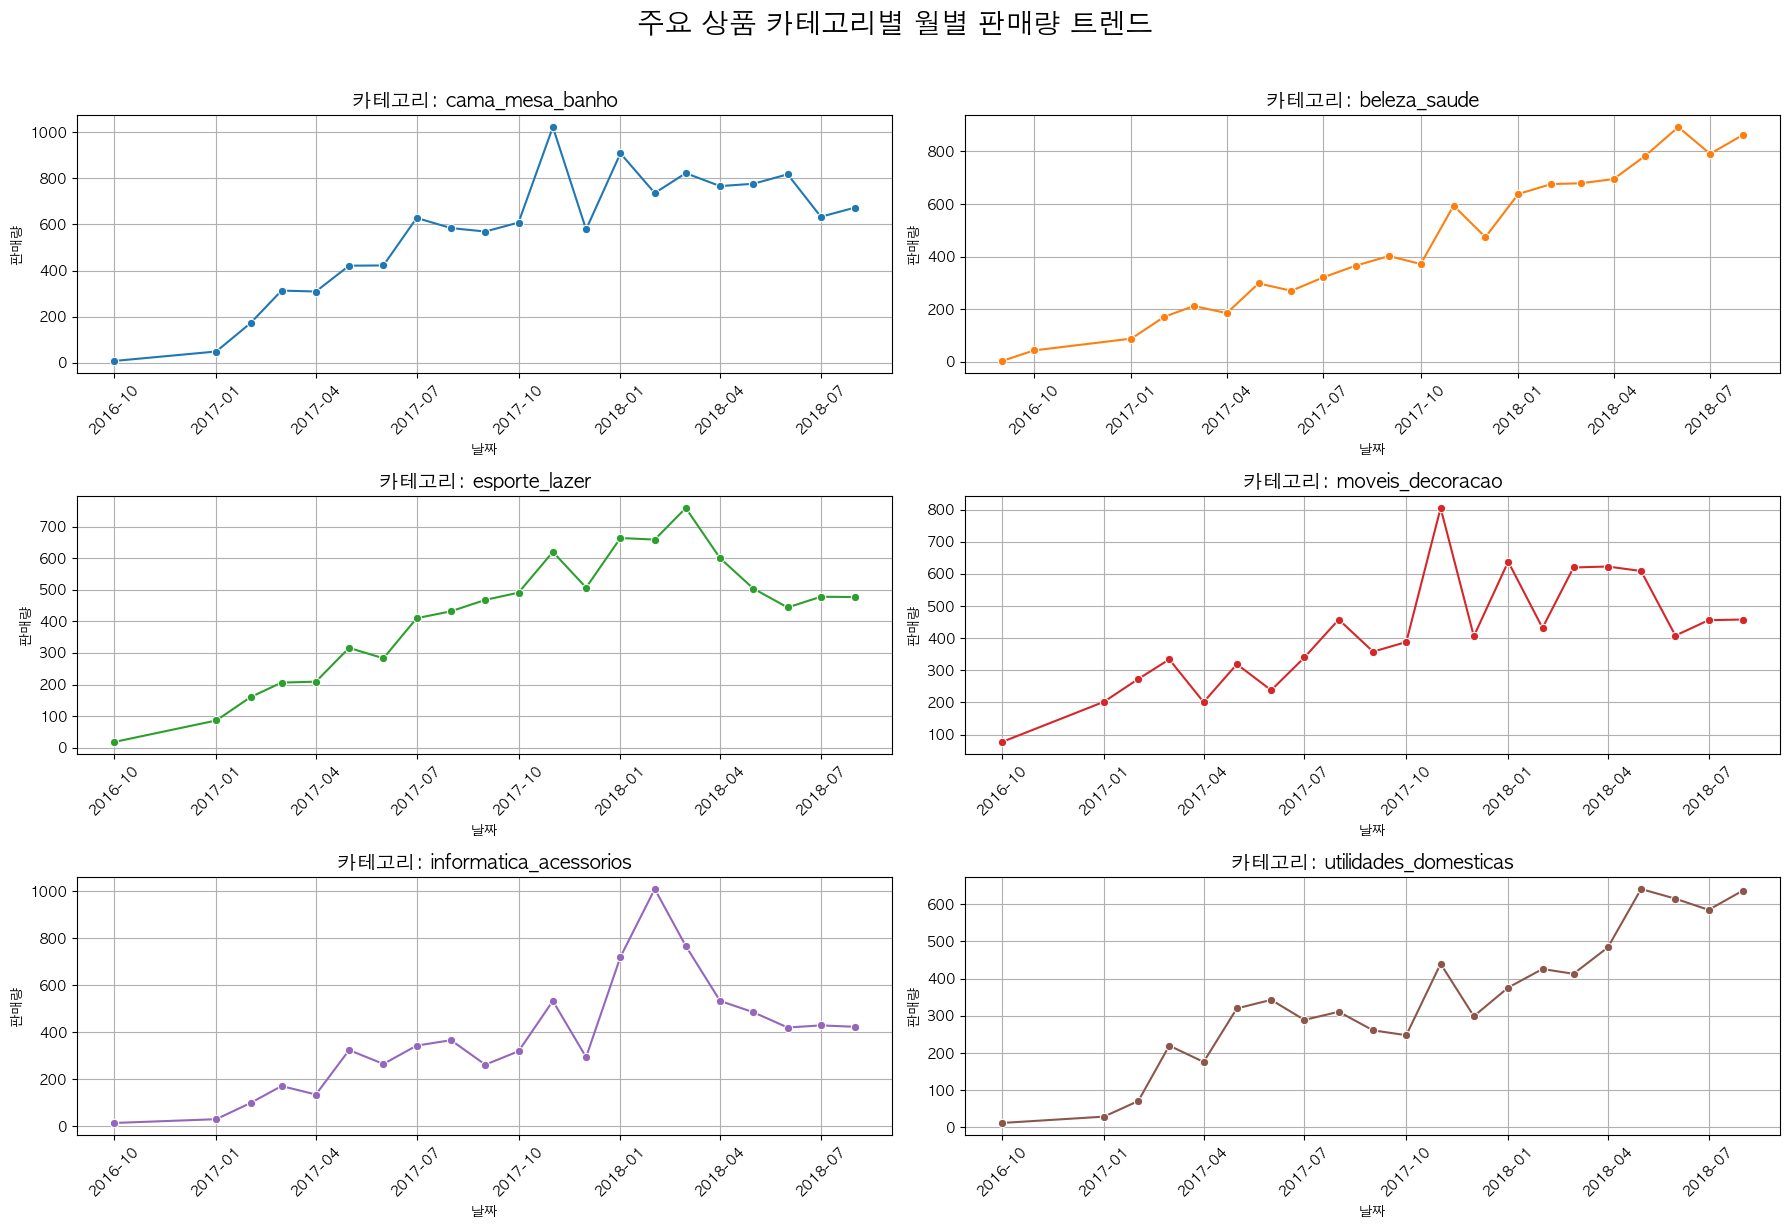


=== 판매량 집계 결과 미리보기 ===
  order_month product_category_name  sales_count
0     2016-09          beleza_saude            3
1     2016-10             alimentos            1
2     2016-10                 audio            2
3     2016-10            automotivo            8
4     2016-10                 bebes           11


In [8]:
# =================================================================
# 3. 시계열 트렌드 및 계절성 시각화
# =================================================================

plt.figure(figsize=(18, 12))
plt.suptitle('주요 상품 카테고리별 월별 판매량 트렌드', fontsize=20, y=1.02)

# 상위 6개 카테고리에 대해 그래프 생성
for i, category in enumerate(top_categories):
    plt.subplot(3, 2, i + 1)
    
    # 해당 카테고리 데이터 필터링
    category_data = monthly_sales_by_category[monthly_sales_by_category['product_category_name'] == category]
    
    # x축을 시간 순서로 정렬
    category_data['order_month_dt'] = category_data['order_month'].dt.to_timestamp()
    
    sns.lineplot(x='order_month_dt', y='sales_count', data=category_data, marker='o', color=f'C{i}')
    plt.title(f'카테고리: {category}', fontsize=14)
    plt.xlabel('날짜')
    plt.ylabel('판매량')
    plt.grid(True)
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

print("\n=== 판매량 집계 결과 미리보기 ===")
print(monthly_sales_by_category.head())


제공된 그래프들을 통해 다음과 같은 몇 가지 중요한 판매 트렌드를 해석할 수 있습니다.

### 1. 전반적인 판매량 증가 추세

대부분의 상위 카테고리(health_beauty, esporte_lazer, moveis_decoracao, informatica_acessorios, utilidades_domesticas)는 2016년 말부터 2018년 초까지 **지속적인 판매량 증가 추세**를 보이고 있습니다. 이는 Olist 플랫폼의 성장이 주요 원인일 수 있습니다.

### 2. 카테고리별 계절성 및 특이점

* **cama_mesa_banho (침대/욕실/주방 용품)**: 이 카테고리는 2017년 말(특히 11월)과 2018년 초에 눈에 띄게 판매량이 급증했습니다. 이는 블랙 프라이데이, 연말연시와 같은 명절 및 쇼핑 시즌의 영향을 받았을 가능성이 높습니다.
* **beleza_saude (뷰티/건강)**: 꾸준히 성장하는 모습을 보이며, 특정 시기에 큰 폭의 판매량 증가는 없지만, 전반적인 수요가 안정적으로 증가하고 있음을 보여줍니다.
* **moveis_decoracao (가구/인테리어 소품)**: 이 카테고리 역시 2017년 말에 뚜렷한 판매량 증가를 보였습니다. 크리스마스 등 연말을 앞두고 집을 꾸미려는 수요가 반영된 것으로 해석할 수 있습니다.
* **informatica_acessorios (컴퓨터/액세서리)**: 2018년 초에 판매량이 급증했다가 이후 소폭 감소했습니다. 이는 신학기 준비나 특정 IT 제품 출시 등의 요인에 영향을 받았을 수 있습니다.
* **utilidades_domesticas (생활용품)**: 2018년 초부터 꾸준히 판매량이 증가하고 있으며, 특히 2018년 3월 이후 가파른 성장세를 보입니다.

### 3. 비즈니스 인사이트 도출

이러한 분석을 통해 몇 가지 비즈니스 전략을 수립할 수 있습니다.

* **시기별 프로모션**: `cama_mesa_banho`나 `moveis_decoracao`와 같이 특정 시기에 판매량이 급증하는 카테고리에는 연말 프로모션을 강화하여 판매를 극대화할 수 있습니다.
* **재고 관리**: `beleza_saude`와 같이 꾸준히 성장하는 카테고리는 재고를 안정적으로 확보하여 지속적인 수요에 대응해야 합니다.
* **새로운 기회 탐색**: 2018년 초반에 높은 판매량을 보인 `informatica_acessorios`는 해당 시기에 맞춰 특정 제품군(예: 노트북, 모니터)의 공급을 늘리거나 관련 이벤트를 기획할 수 있습니다.

결론적으로, 그래프는 플랫폼 전체가 성장하고 있음을 보여주면서도, 각 카테고리가 고유한 판매 패턴과 계절성을 가지고 있음을 명확히 보여주고 있습니다.

In [9]:
%pip install tabulate


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install tabulate


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


=== 수요 예측 및 재고 관리 제언 ===
| category               |   actual_sales |   predicted_sales |   difference | strategy                                                                                                                           |
|:-----------------------|---------------:|------------------:|-------------:|:-----------------------------------------------------------------------------------------------------------------------------------|
| cama_mesa_banho        |            673 |               742 |         -113 | 안정적인 판매 추세를 보이므로, 예측 모델을 기반으로 꾸준히 재고를 확보하고, 공급망을 최적화하여 비용을 절감하는 전략이 유효합니다. |
| beleza_saude           |            863 |               823 |           72 | 높은 계절성을 보이므로, 특정 시즌(예: 연말연시) 전에 재고를 대량 확보하고, 시즌 이후에는 재고 부담을 줄이는 전략이 필요합니다.     |
| esporte_lazer          |            477 |               475 |          -39 | 안정적인 판매 추세를 보이므로, 예측 모델을 기반으로 꾸준히 재고를 확보하고, 공급망을 최적화하여 비용을 절감하는 전략이 유효합니다. |
| moveis_decoracao       |            458 |               491 |          -89 | 

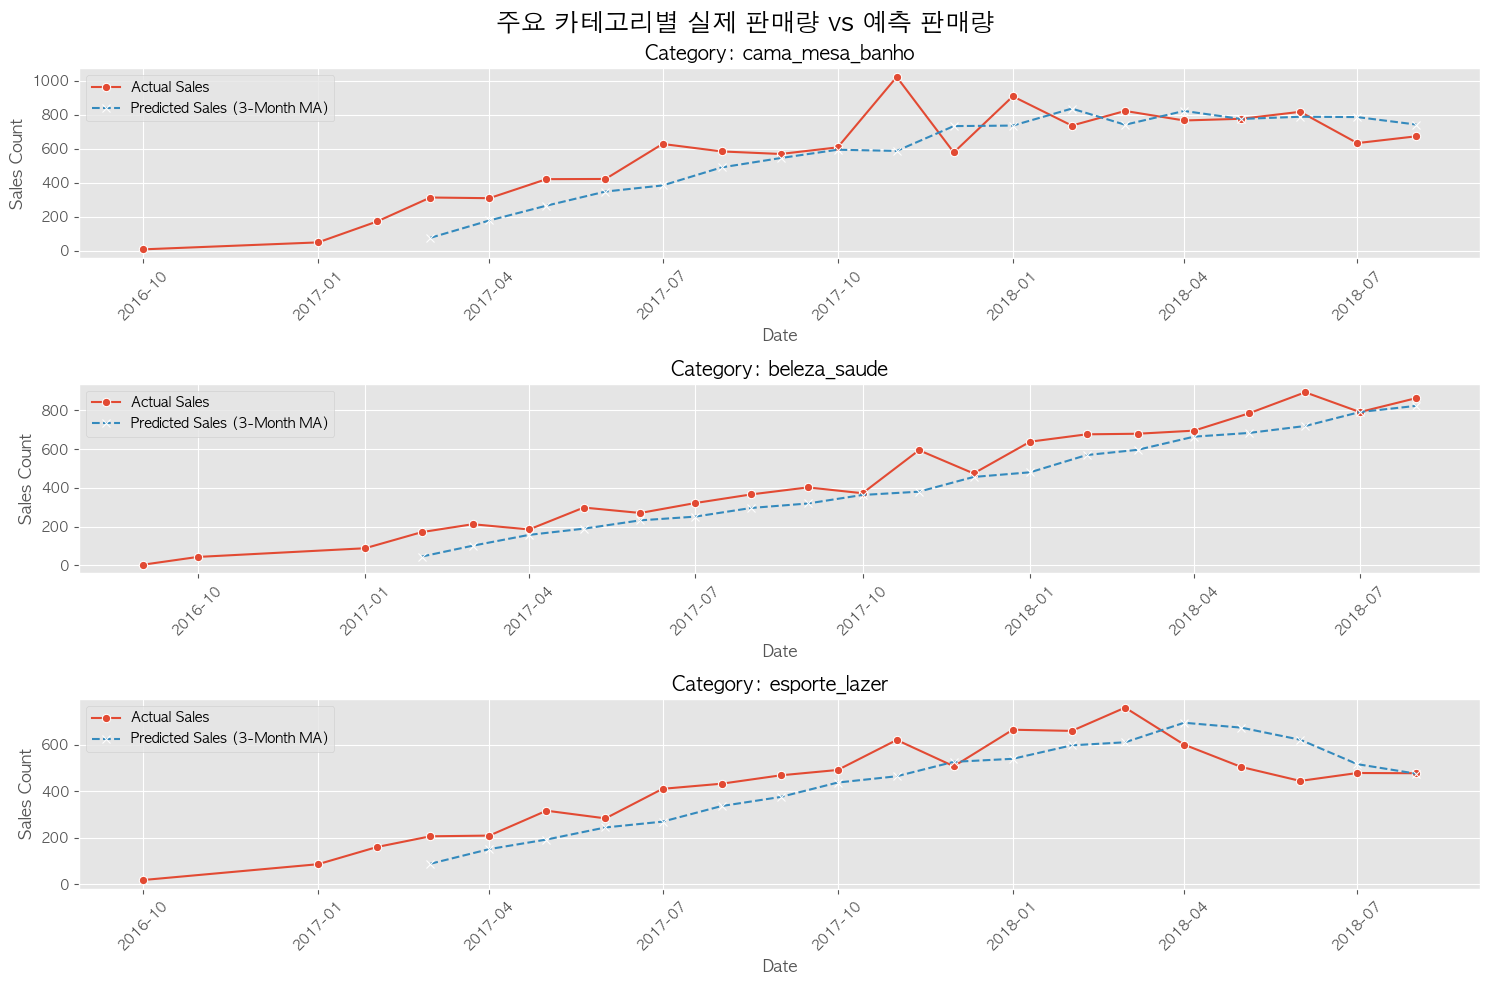

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)
plt.style.use('ggplot')


# =================================================================
# 2. 월별 판매량 집계 및 주요 카테고리 선정
# =================================================================

# 'order_purchase_timestamp'를 기준으로 월(Month) 컬럼 생성
df_merged['order_month'] = df_merged['order_purchase_timestamp'].dt.to_period('M')

# 카테고리별 월별 판매량 집계
monthly_sales_by_category = df_merged.groupby(['order_month', 'product_category_name']).size().reset_index(name='sales_count')

# 전체 판매량이 많은 상위 10개 카테고리 선정
top_categories = df_merged.groupby('product_category_name').size().sort_values(ascending=False).index[:10]

# =================================================================
# 3. 수요 예측 및 재고 관리 제언
# =================================================================

# 예측 결과를 담을 데이터프레임 생성
predictions = pd.DataFrame(columns=['category', 'actual_sales', 'predicted_sales', 'difference', 'strategy'])

for category in top_categories:
    # 해당 카테고리 데이터 필터링 및 시계열 데이터 정렬
    category_data = monthly_sales_by_category[monthly_sales_by_category['product_category_name'] == category].sort_values('order_month')
    
    # 이동 평균(Moving Average) 예측: 과거 3개월 평균 사용
    category_data['predicted_sales'] = category_data['sales_count'].rolling(window=3).mean().shift(1).round(0)
    
    # 마지막 월의 실제 판매량과 다음 달 예측값 가져오기
    last_month_sales = category_data['sales_count'].iloc[-1]
    next_month_prediction = category_data['predicted_sales'].iloc[-1]
    
    # 실제 판매량과 예측값의 차이 계산 (마지막 예측값 기준)
    difference = last_month_sales - category_data['predicted_sales'].iloc[-2] if len(category_data) > 2 else 0
    
    # 재고 관리 전략 제언 (간단한 규칙 기반)
    strategy = ""
    # 판매량의 변동성이 큰 경우 (높은 계절성)
    if category_data['sales_count'].max() / category_data['sales_count'].mean() > 2:
        strategy = "높은 계절성을 보이므로, 특정 시즌(예: 연말연시) 전에 재고를 대량 확보하고, 시즌 이후에는 재고 부담을 줄이는 전략이 필요합니다."
    # 판매량의 변동성이 적은 경우 (안정적)
    else:
        strategy = "안정적인 판매 추세를 보이므로, 예측 모델을 기반으로 꾸준히 재고를 확보하고, 공급망을 최적화하여 비용을 절감하는 전략이 유효합니다."
        
    # 예측 결과 및 전략을 DataFrame에 추가
    predictions.loc[len(predictions)] = [
        category, 
        last_month_sales, 
        next_month_prediction, 
        difference,
        strategy
    ]

# 결과 출력
print("=== 수요 예측 및 재고 관리 제언 ===")
print(predictions.to_markdown(index=False))

# 시각화: 실제 판매량과 예측값 비교 (상위 3개 카테고리)
plt.figure(figsize=(15, 10))
plt.suptitle('주요 카테고리별 실제 판매량 vs 예측 판매량', fontsize=18)

for i, category in enumerate(top_categories[:3]):
    plt.subplot(3, 1, i + 1)
    
    category_data = monthly_sales_by_category[monthly_sales_by_category['product_category_name'] == category].sort_values('order_month')
    category_data['predicted_sales'] = category_data['sales_count'].rolling(window=3).mean().shift(1).round(0)

    # 그래프 그리기
    sns.lineplot(x=category_data['order_month'].dt.to_timestamp(), y='sales_count', data=category_data, label='Actual Sales', marker='o')
    sns.lineplot(x=category_data['order_month'].dt.to_timestamp(), y='predicted_sales', data=category_data, label='Predicted Sales (3-Month MA)', marker='x', linestyle='--')
    
    plt.title(f'Category: {category}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Sales Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
plt.tight_layout()
plt.show()
